**Distratced Driving Detection using Keras in R**

In [ ]:
#Load the libraries
library(tidyverse)
library(keras)

**List Files**

In [ ]:
list.files("../input/state-farm-distracted-driver-detection")

list.files('../input/state-farm-distracted-driver-detection/imgs/train')

head(list.files('../input/state-farm-distracted-driver-detection/imgs/test'))

head(read.csv('../input/state-farm-distracted-driver-detection/sample_submission.csv'))

head(read.csv('../input/state-farm-distracted-driver-detection/driver_imgs_list.csv'))

**Build Generators**

In [ ]:
train_dir <- '../input/state-farm-distracted-driver-detection/imgs/train'
test_dir <- '../input/state-farm-distracted-driver-detection/imgs/test'

train_datagen = image_data_generator(rescale = 1/255, data_format='channels_last', validation_split=.5)
test_datagen <- image_data_generator(rescale = 1/255, data_format='channels_last')  

train_generator <- flow_images_from_directory(
  train_dir,                  # Target directory  
  train_datagen,              # Data generator
  target_size = c(256, 256),  # Resizes all images
  batch_size = 4,
  class_mode = "categorical",       
  subset='training'
)

validation_generator <- flow_images_from_directory(
  train_dir,                  # Target directory  
  train_datagen,              # Data generator
  target_size = c(256, 256),  # Resizes all images
  batch_size = 4,
  class_mode = "categorical",       
  subset='validation'
)

test_generator <- flow_images_from_directory(
  test_dir,                  # Target directory  
  test_datagen,              # Data generator
  target_size = c(256, 256),  # Resizes all images
  batch_size = 4,
  shuffle=FALSE,
  class_mode = NULL
)

** Build Model**

In [11]:
model <- keras_model_sequential()

model %>%
  
  # Start with hidden 2D convolutional layer being fed 32x32 pixel images
  layer_conv_2d(
    filter = 16, kernel_size = c(2), padding = "same", 
    input_shape = c(256, 256, 3),
      activation='relu') %>%
  layer_batch_normalization() %>%
  # Second hidden layer
  layer_conv_2d(filter = 128, kernel_size = c(2), activation='relu') %>%
  layer_batch_normalization() %>%    

  # Use max pooling
  layer_max_pooling_2d(pool_size = c(2)) %>%
  layer_dropout(rate=.2) %>%
      
  # 1 additional hidden 2D convolutional layers
  layer_conv_2d(filter = 64, kernel_size = c(4), padding = "same", activation='relu') %>%
  layer_batch_normalization() %>%
  layer_conv_2d(filter = 64, kernel_size = c(4), activation='relu') %>%
  layer_batch_normalization() %>%

  layer_max_pooling_2d(pool_size = c(2)) %>%
  layer_dropout(rate=.2) %>%

  # Flatten max filtered output into feature vector 
  # and feed into dense layer
  layer_flatten() %>%
  #layer_dropout(rate=.2) %>%
  #layer_dense(128, activaton='relu') %>% 
  
  # Outputs from dense layer are projected onto 10 unit output layer
  layer_dense(10, activation='softmax')

In [12]:
str(model)

Model
Model: "sequential_4"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_16 (Conv2D)                  (None, 256, 256, 16)            208         
________________________________________________________________________________
batch_normalization_16 (BatchNormal (None, 256, 256, 16)            64          
________________________________________________________________________________
conv2d_17 (Conv2D)                  (None, 255, 255, 128)           8320        
________________________________________________________________________________
batch_normalization_17 (BatchNormal (None, 255, 255, 128)           512         
________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)      (None, 127, 127, 128)           0           
________________________________________________________________________________


**Compile Model**

In [13]:
opt <- optimizer_rmsprop(lr = 0.0001, decay = 1e-6)

model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = opt,
  metrics = "accuracy"
)

**Fit Model**

`geom_smooth()` using formula 'y ~ x'



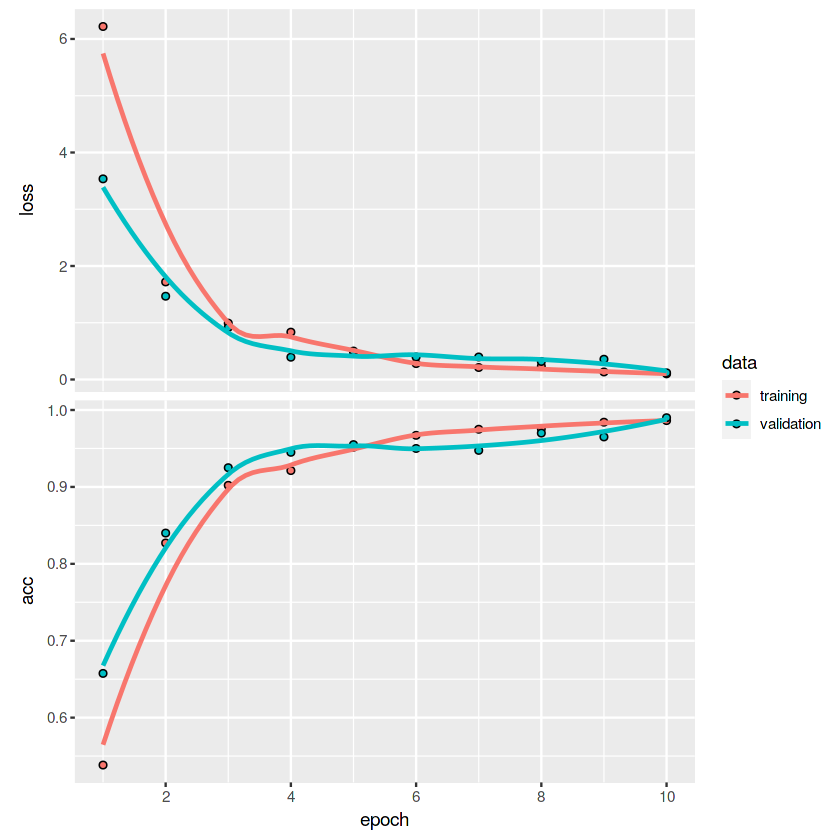

In [14]:
history <- model %>% fit_generator(
  train_generator,
  steps_per_epoch = 600,
  epochs = 10,
  validation_data=validation_generator,
  validation_steps=100
)

plot(history)

In [15]:
model %>% evaluate_generator(train_generator, steps=50)

$loss
[1] 0.02175396

$acc
[1] 0.995

**** Evaluate Model ****

In [16]:
model %>% evaluate_generator(validation_generator, steps=50)

$loss
[1] 0.003106567

$acc
[1] 1

**Test Ramdom Example**

[1] "Safe Driving"

V1,class
<dbl>,<chr>
1,Safe Driving
0,texting - right
0,talking on the phone - right
0,texting - left
0,talking on the phone - left
0,operating the radio
0,drinking
0,reaching behind
0,hair and makeup


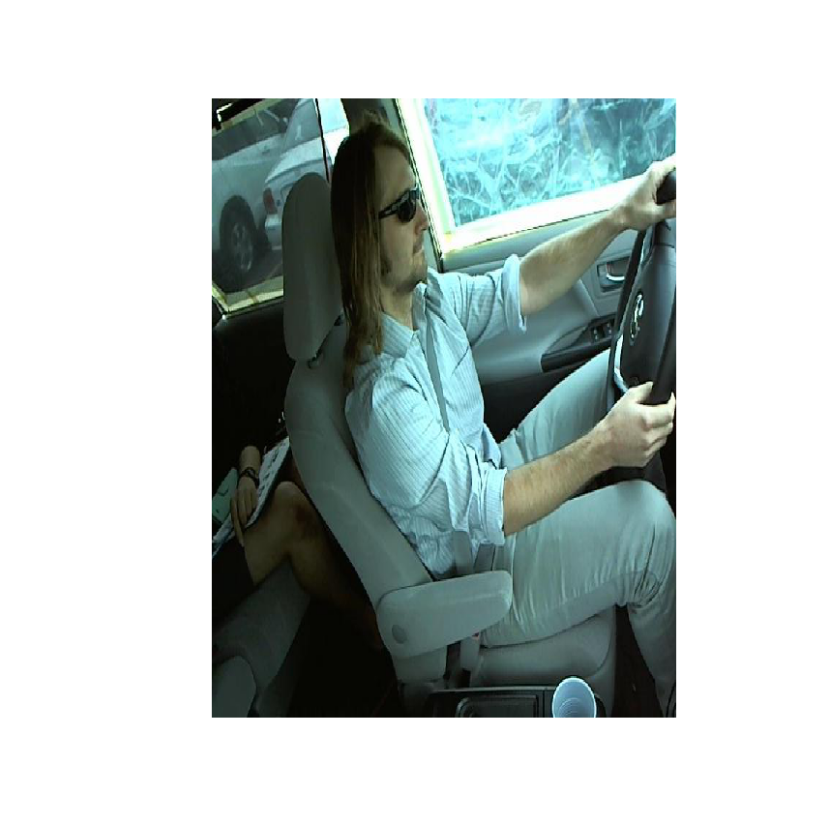

In [19]:
classes <- c('Safe Driving', 'texting - right', 'talking on the phone - right', 'texting - left',
             'talking on the phone - left', 'operating the radio', 'drinking', 'reaching behind',
             'hair and makeup', 'talking to passenger')

file <- sample(list.files(test_dir),1)

img_path <- paste(test_dir, file, sep='/')         
img <- image_load(img_path, target_size = c(256, 256)) %>%           
  image_to_array() %>%                                               
  array_reshape(dim = c(1, 256, 256, 3)) 


p_class <- predict_classes(model, img)
preds <- as.data.frame(t(predict_proba(model, img)))
preds$class <- classes


classes[p_class+1]
preds


img_ <- image_load(img_path, target_size = c(640, 480)) %>%           
  image_to_array() %>%                                               
  array_reshape(dim = c(1, 640, 480, 3)) 


img_tensor=img_/255
plot(as.raster(img_tensor[1,,,]))

[1] "texting - right"

V1,class
<dbl>,<chr>
0,Safe Driving
1,texting - right
0,talking on the phone - right
0,texting - left
0,talking on the phone - left
0,operating the radio
0,drinking
0,reaching behind
0,hair and makeup


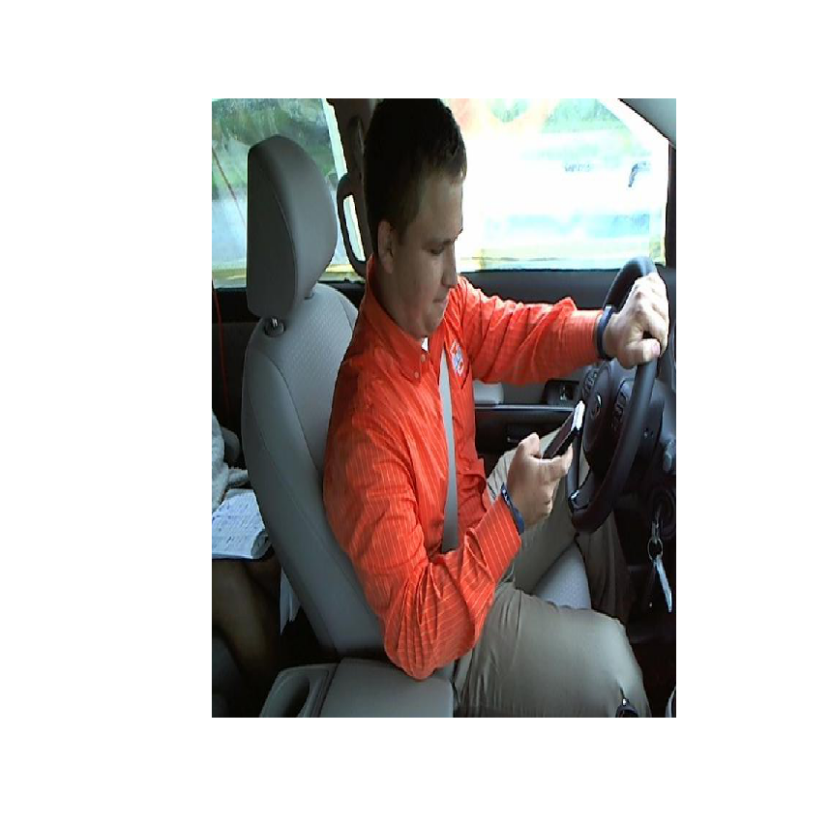

In [21]:
#classes <- c('Safe Driving', 'texting - right', 'talking on the phone - right', 'texting - left',
#             'talking on the phone - left', 'operating the radio', 'drinking', 'reaching behind',
#             'hair and makeup', 'talking to passenger')

file <- sample(list.files(test_dir),1)

img_path <- paste(test_dir, file, sep='/')         
img <- image_load(img_path, target_size = c(256, 256)) %>%           
  image_to_array() %>%                                               
  array_reshape(dim = c(1, 256, 256, 3)) 


p_class <- predict_classes(model, img)
preds <- as.data.frame(t(predict_proba(model, img)))
preds$class <- classes


classes[p_class+1]
preds


img_ <- image_load(img_path, target_size = c(640, 480)) %>%           
  image_to_array() %>%                                               
  array_reshape(dim = c(1, 640, 480, 3)) 


img_tensor=img_/255
plot(as.raster(img_tensor[1,,,]))

[1] "talking to passenger"

V1,class
<dbl>,<chr>
0,Safe Driving
0,texting - right
0,talking on the phone - right
0,texting - left
0,talking on the phone - left
0,operating the radio
0,drinking
0,reaching behind
0,hair and makeup


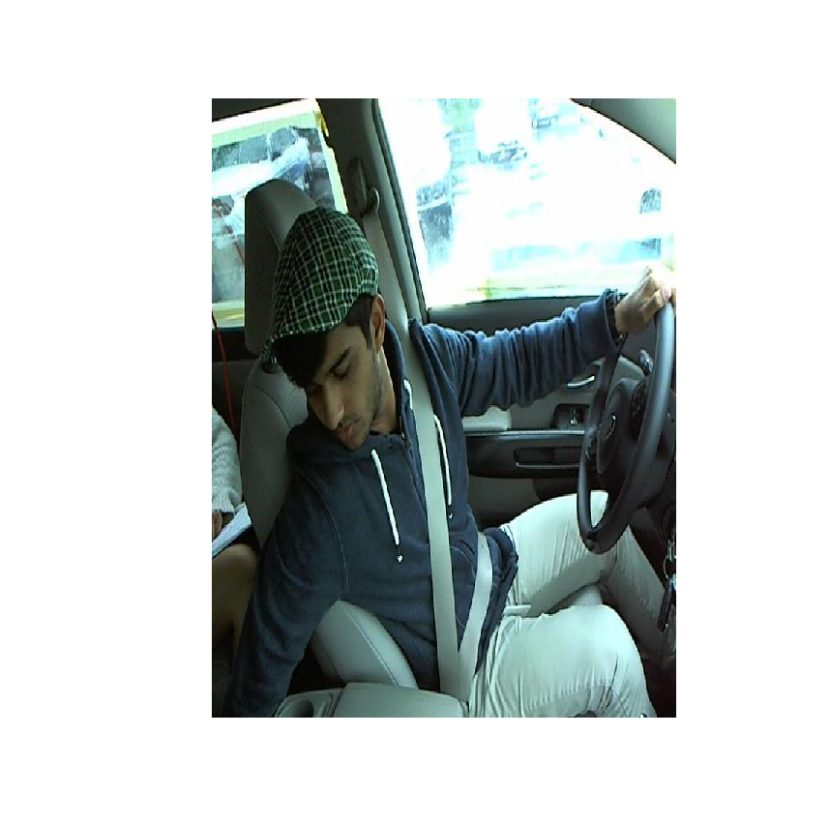

In [30]:
#classes <- c('Safe Driving', 'texting - right', 'talking on the phone - right', 'texting - left',
#             'talking on the phone - left', 'operating the radio', 'drinking', 'reaching behind',
#             'hair and makeup', 'talking to passenger')

file <- sample(list.files(test_dir),1)

img_path <- paste(test_dir, file, sep='/')         
img <- image_load(img_path, target_size = c(256, 256)) %>%           
  image_to_array() %>%                                               
  array_reshape(dim = c(1, 256, 256, 3)) 


p_class <- predict_classes(model, img)
preds <- as.data.frame(t(predict_proba(model, img)))
preds$class <- classes


classes[p_class+1]
preds


img_ <- image_load(img_path, target_size = c(640, 480)) %>%           
  image_to_array() %>%                                               
  array_reshape(dim = c(1, 640, 480, 3)) 


img_tensor=img_/255
plot(as.raster(img_tensor[1,,,]))

[1] "texting - right"

V1,class
<dbl>,<chr>
0,Safe Driving
1,texting - right
0,talking on the phone - right
0,texting - left
0,talking on the phone - left
0,operating the radio
0,drinking
0,reaching behind
0,hair and makeup


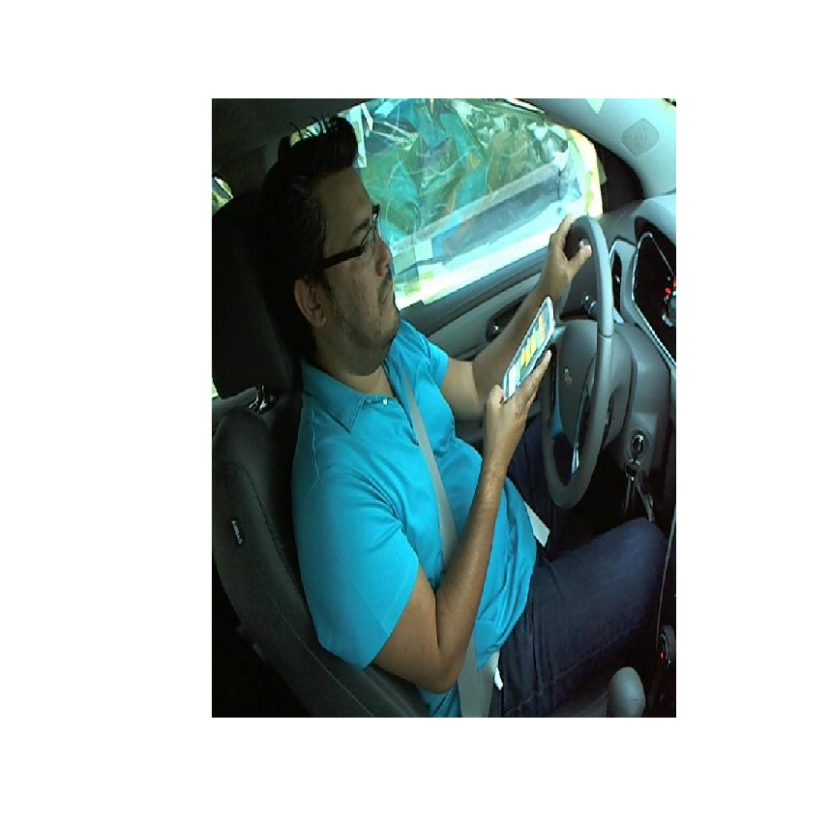

In [32]:
#classes <- c('Safe Driving', 'texting - right', 'talking on the phone - right', 'texting - left',
#             'talking on the phone - left', 'operating the radio', 'drinking', 'reaching behind',
#             'hair and makeup', 'talking to passenger')

file <- sample(list.files(test_dir),1)

img_path <- paste(test_dir, file, sep='/')         
img <- image_load(img_path, target_size = c(256, 256)) %>%           
  image_to_array() %>%                                               
  array_reshape(dim = c(1, 256, 256, 3)) 


p_class <- predict_classes(model, img)
preds <- as.data.frame(t(predict_proba(model, img)))
preds$class <- classes


classes[p_class+1]
preds


img_ <- image_load(img_path, target_size = c(640, 480)) %>%           
  image_to_array() %>%                                               
  array_reshape(dim = c(1, 640, 480, 3)) 


img_tensor=img_/255
plot(as.raster(img_tensor[1,,,]))

**Save Model**

In [ ]:
save_model_hdf5(model, 'model_v6.h5', overwrite = TRUE,
  include_optimizer = TRUE)